In [9]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import utils
from model01 import MLPModel01
from preprocess import prepare_data

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import keras

In [2]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_recall_curve, confusion_matrix

In [3]:
def performance_report(name, true_class, predicted_class):
    print("------------------------------------------------------")
    print(name)
    print("f1-score: {:.3f}".format(f1_score(true_class, predicted_class), average='weighted'))
    #print("accuracy: {:.3f}".format(accuracy_score(true_class, predicted_class)))
    print(classification_report(true_class, predicted_class ))

In [44]:
lookahead = 1
n_categories = 2
layer_widths = [100, 100,100,100]
dropout = 0.5
window = 60

In [45]:
X_train, Y_train = prepare_data(utils.load_1minute_fx_bars("USDJPY", 2009), lookahead=lookahead, window=window)
X_test, Y_test = prepare_data(utils.load_1minute_fx_bars("USDJPY", 2010), lookahead=lookahead, window=window)

print (X_train.shape)
n_features = X_train.shape[1]
print ("n_features:", n_features)

(343456, 243)
n_features: 243


In [36]:
from sklearn.linear_model import SGDClassifier
lin_model = SGDClassifier(loss='hinge', penalty='l2', n_iter=200, n_jobs=10)
lin_model.fit(X_train.as_matrix(), Y_train)

print( "train f1", f1_score(Y_train, lin_model.predict(X_train), average='weighted') )
print( "test f1", f1_score(Y_test, lin_model.predict(X_test), average='weighted'))

train f1 0.568296719923
test f1 0.571899460596


In [37]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(n_jobs=10)
lr_model.fit(X_train.as_matrix(), Y_train)

print( "train f1", f1_score(Y_train, lr_model.predict(X_train), average='weighted') )
print( "test f1", f1_score(Y_test, lr_model.predict(X_test), average='weighted'))

train f1 0.572730055713
test f1 0.584811441278


In [38]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_depth=5, n_jobs=12)
rf_model.fit(X_train.as_matrix(), Y_train)

print( "train f1", f1_score(Y_train, rf_model.predict(X_train), average='weighted') )
print( "test f1", f1_score(Y_test, rf_model.predict(X_test), average='weighted'))

train f1 0.583203907571
test f1 0.574094897967


In [46]:
model = MLPModel01(lookahead, n_features, n_categories, layer_widths, dropout)
print (model.summary())

compilation took: 0.1 seconds
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_13 (Dense)                 (None, 100)           24400       dense_input_4[0][0]              
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 100)           0           dense_13[0][0]                   
____________________________________________________________________________________________________
dense_14 (Dense)                 (None, 100)           10100       dropout_5[0][0]                  
____________________________________________________________________________________________________
dropout_6 (Dropout)              (None, 100)           0           dense_14[0][0]                   
_____________________________________________________________

In [47]:
n_epochs = 200

hist = model.model.fit(
    X_train.as_matrix(), Y_train, 
    verbose=0, validation_split=0.10, batch_size=1024*50, 
    nb_epoch=n_epochs,
    callbacks = [])

In [48]:
Y_train_pred = model.model.predict(X_train.as_matrix(), batch_size=1024)
Y_train_pred_class = 1*(Y_train_pred > 0.5)
Y_test_pred = model.model.predict(X_test.as_matrix(), batch_size=1024)
Y_test_pred_class = 1*(Y_test_pred > 0.5)

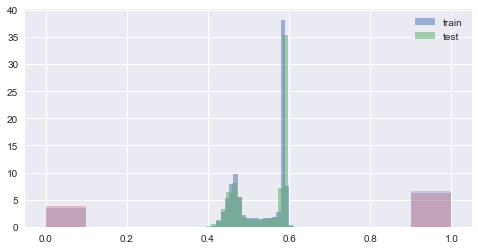

In [49]:
plt.figure(figsize=(8,4))
plt.hist(Y_train_pred, alpha=0.5, bins=30, normed=True, label='train')
plt.hist(Y_test_pred, alpha=0.5, bins=30, normed=True, label='test')
plt.hist(Y_train_pred_class, alpha=0.3, normed=True)
plt.hist(Y_test_pred_class, alpha=0.3, normed=True)
plt.legend()

------------------------------------------------------
train
f1-score: 0.637
             precision    recall  f1-score   support

          0       0.61      0.46      0.53    169201
          1       0.58      0.71      0.64    174255

avg / total       0.59      0.59      0.58    343456

------------------------------------------------------
test
f1-score: 0.649
             precision    recall  f1-score   support

          0       0.58      0.43      0.49    154179
          1       0.59      0.72      0.65    174657

avg / total       0.58      0.58      0.58    328836



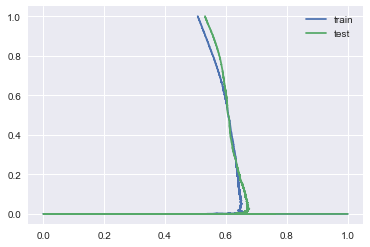

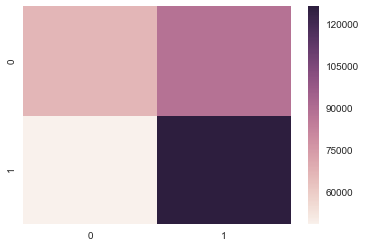

In [57]:
performance_report("train", Y_train, Y_train_pred_class)
performance_report("test", Y_test, Y_test_pred_class)

train_curve = precision_recall_curve(Y_train, Y_train_pred)
test_curve = precision_recall_curve(Y_test, Y_test_pred)

plt.plot(train_curve[0], train_curve[1], label='train')
plt.plot(test_curve[0], test_curve[1], label='test')
plt.legend()
plt.show()
sns.heatmap(confusion_matrix(Y_test, Y_test_pred_class))

dropout = 0  , lookahead = 1

| width | layers    | epochs | train | test |
| -----: | ---- :     | ---:    | ---:   | ---:  |
| 1     | 1         |  100   | .57   | .58  |
| 1     | 100       |  100   | .58   | .59  |
| 1     | 100       |  500   | .57   | .59  |
| 1     | 100 x 100 |  100 | .58   | .59  |
| 10    | 1         |  100 |  .57  | .59  |
| 10    | 10        |  100 |  .57  | .58  |
| 10    | 100       |  100 |  .58 | .58   |
| 10    | 100 x 100 |  100 |  .60 | .58   |
| 10    | 100 x 100 x 100 |  100 |  .62 | .57   |
| 10    | 100 x 100 x 100 x 100 |  100 |  .63 | .56   |
| 20    | 1 |  100 |  .56 | .58  |
| 20    | 100 |  100 | .58  | .58  |
| 40    | 100 |  500 x 500 x 500 | .60  | .61  |

Dropout = 0.1, lookahead = 1 

| width | layers    | epochs | train | test |
| -----: | ---- :     | ---:    | ---:   | ---:  |
| 10    | 100 x 100 x 100 x 100 |  100 | .60  | .58  |
| 10    | 100 x 100 x 100 x 100 |  200 | .62  | .58  |


Dropout = 0.2, lookahead = 1 

| width | layers    | epochs | train | test |
| -----: | ---- :     | ---:    | ---:   | ---:  |
| 10    | 100 x 100 x 100 x 100 |  100 | .59 | .59  |
| 10    | 100 x 100 x 100 x 100 |  200 | .60 | .58  |

Dropout = 0.5, lookeahead = 1

| width | layers    | epochs | train | test |
| -----: | ---- :     | ---:    | ---:   | ---:  |
| 60    | 500 x 500 x 500 x 500 |  200 | .64 | .62|
| 60    | 100 x 100 x 100 x 100 |  200 | .64 | .65



In [55]:
from sklearn.metrics import log_loss
print (log_loss(Y_test, Y_test_pred))
print (log_loss(Y_train, Y_train_pred))

print (accuracy_score(Y_test, Y_test_pred_class))
print (accuracy_score(Y_train, Y_train_pred_class))

0.677912181553
0.67812168676
0.584942037976
0.589047796515


array([0, 1, 0, ..., 1, 1, 0])